# Imports

In [1]:
!pip install -q econml rpy2 dowhy dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 8.3 MB/s eta 0:00:00


In [2]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

In [3]:
from rpy2.robjects import r as R
import pandas as pd

%load_ext rpy2.ipython
%R install.packages("Matching")
%R library(Matching)
%R data(lalonde)
%R -o lalonde
lalonde.to_csv("lalonde.csv", index=False)

(as ‘lib’ is unspecified)







	‘/tmp/RtmphegiW8/downloaded_packages’


##  Matching (Version 4.10-14, Build Date: 2023-09-13)
##  See https://www.jsekhon.com for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from econml.dml import LinearDML, CausalForestDML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import dowhy.api

# Load Data

In [5]:
# LaLonde DataFrame
lalonde = pd.read_csv("lalonde.csv")
lalonde.head()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [6]:
# DoWhy DataFrame
do_df = lalonde.causal.do(
    x='treat',
    outcome='re78',
    common_causes=['nodegr', 'black', 'hisp', 'age', 'educ', 'married'],
    variable_types={'age': 'c', 'educ':'c', 'black': 'd', 'hisp': 'd',
                    'married': 'd', 'nodegr': 'd','re78': 'c', 'treat': 'b'}
)
do_df.head()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat,propensity_score,weight
0,48,4,1,0,0,1,0.00,0.0000,6551.59,1,1,1,0.485821,2.058372
1,20,9,0,1,0,1,12260.80,5875.0500,1358.64,0,0,1,0.272019,3.676219
2,30,8,1,0,0,1,0.00,1706.6600,0.00,1,0,0,0.593812,1.684034
3,17,9,0,1,0,1,445.17,74.3435,6210.67,0,0,1,0.268053,3.730612
4,26,12,1,0,1,0,0.00,0.0000,6191.94,1,1,0,0.408041,2.450734


In [7]:
# Define the data
X = lalonde[['age', 'educ', 'black', 'hisp', 'married', 'nodegr']]
D = lalonde['treat'].values  # Convert to 1D array
y = lalonde['re78'].values   # Convert to 1D array

In [8]:
# Define models (parametric and non-parametric)
parametric_model_y = LinearRegression()
parametric_model_t = LogisticRegression()

non_parametric_model_y = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)
non_parametric_model_t = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)

# Perform DML with different models
ates_dict = {}
residuals_dict = {}

# Manual Implementation

In [9]:
# DML implementation (parametric or non-parametric)
def dml(X, D, y, model_y, model_t, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
    ates = []
    residuals = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        D_train, D_test = D[train_index], D[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Estimate nuisance function g(X) for the outcome
        model_y.fit(X_train, y_train)
        g_X_train = model_y.predict(X_train)
        g_X_test = model_y.predict(X_test)

        # Estimate nuisance function m(X) for the treatment
        model_t.fit(X_train, D_train)
        if isinstance(model_t, LogisticRegression) or isinstance(model_t, RandomForestClassifier):
            m_X_train = model_t.predict_proba(X_train)[:, 1]
            m_X_test = model_t.predict_proba(X_test)[:, 1]
        else:
            m_X_train = model_t.predict(X_train)
            m_X_test = model_t.predict(X_test)

        # Compute residuals for y and D on both train and test data
        y_residual_train = y_train - g_X_train
        y_residual_test = y_test - g_X_test
        D_residual_train = D_train - m_X_train
        D_residual_test = D_test - m_X_test

        residuals.append((y_residual_test, D_residual_test))

        # Regress the residuals of y on the residuals of D in the training set
        model_effect = LinearRegression()
        model_effect.fit(D_residual_train.reshape(-1, 1), y_residual_train)

        # Predict treatment effect on the test set
        treatment_effect = model_effect.predict(D_residual_test.reshape(-1, 1))

        # Calculate the average treatment effect
        ate = np.mean(treatment_effect)
        ates.append(ate)

    avg_ate = np.mean(ates)
    return avg_ate, residuals

In [10]:
# Manual DML with parametric models
ate, residuals = dml(X, D, y, parametric_model_y, parametric_model_t)
ates_dict['Manual Parametric DML'] = ate
residuals_dict['Manual Parametric DML'] = residuals

In [11]:
# Manual DML with non-parametric models
ate, residuals = dml(X, D, y, non_parametric_model_y, non_parametric_model_t)
ates_dict['Manual Non-Parametric DML'] = ate
residuals_dict['Manual Non-Parametric DML'] = residuals

# EconML Implementation

In [12]:
# DML using econml (parametric or non-parametric)
def econml_dml(X, D, y, model_y, model_t, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
    ates = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        D_train, D_test = D[train_index], D[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create the LinearDML estimator
        estimator = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True)

        # Fit the estimator
        estimator.fit(y_train, D_train, X=X_train)

        # Estimate the treatment effect on the test set
        treatment_effect = estimator.effect(X_test)

        # Calculate the average treatment effect
        ate = np.mean(treatment_effect)
        ates.append(ate)

    avg_ate = np.mean(ates)
    return avg_ate

In [13]:
# econml DML with parametric models
ate = econml_dml(X, D, y, parametric_model_y, parametric_model_t)
ates_dict['econml Parametric DML'] = ate

In [14]:
# econml DML with non-parametric models
ate = econml_dml(X, D, y, non_parametric_model_y, non_parametric_model_t)
ates_dict['econml Non-Parametric DML'] = ate

# Results

In [15]:
# Visualize results
def visualize_results(ates_dict, residuals_dict):
    # Print out ATEs
    for key, ate in ates_dict.items():
        print(f"{key} Estimated Average Treatment Effect (ATE): {ate}")

    # Compare ATEs
    print("\n")
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(ates_dict.keys()), y=list(ates_dict.values()), hue=list(ates_dict.keys()), palette='viridis', errorbar=None)
    plt.title('Comparison of Estimated ATEs')
    plt.ylabel('Average Treatment Effect (ATE)')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    print("\n")

    # Residual distributions
    for key, residuals in residuals_dict.items():
        y_residuals = np.concatenate([r[0] for r in residuals])
        D_residuals = np.concatenate([r[1] for r in residuals])

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(y_residuals, kde=True, color='blue', bins=30)
        plt.title(f'{key} - Outcome Residuals Distribution', fontsize=14, pad=20)

        plt.subplot(1, 2, 2)
        sns.histplot(D_residuals, kde=True, color='green', bins=30)
        plt.title(f'{key} - Treatment Residuals Distribution', fontsize=14, pad=20)

        plt.tight_layout(pad=3.0)
        plt.subplots_adjust(top=0.85)
        plt.show()

Manual Parametric DML Estimated Average Treatment Effect (ATE): 4.115004988315739
Manual Non-Parametric DML Estimated Average Treatment Effect (ATE): 10.1265717002955
econml Parametric DML Estimated Average Treatment Effect (ATE): 1820.4213097548
econml Non-Parametric DML Estimated Average Treatment Effect (ATE): 1680.7851086469193




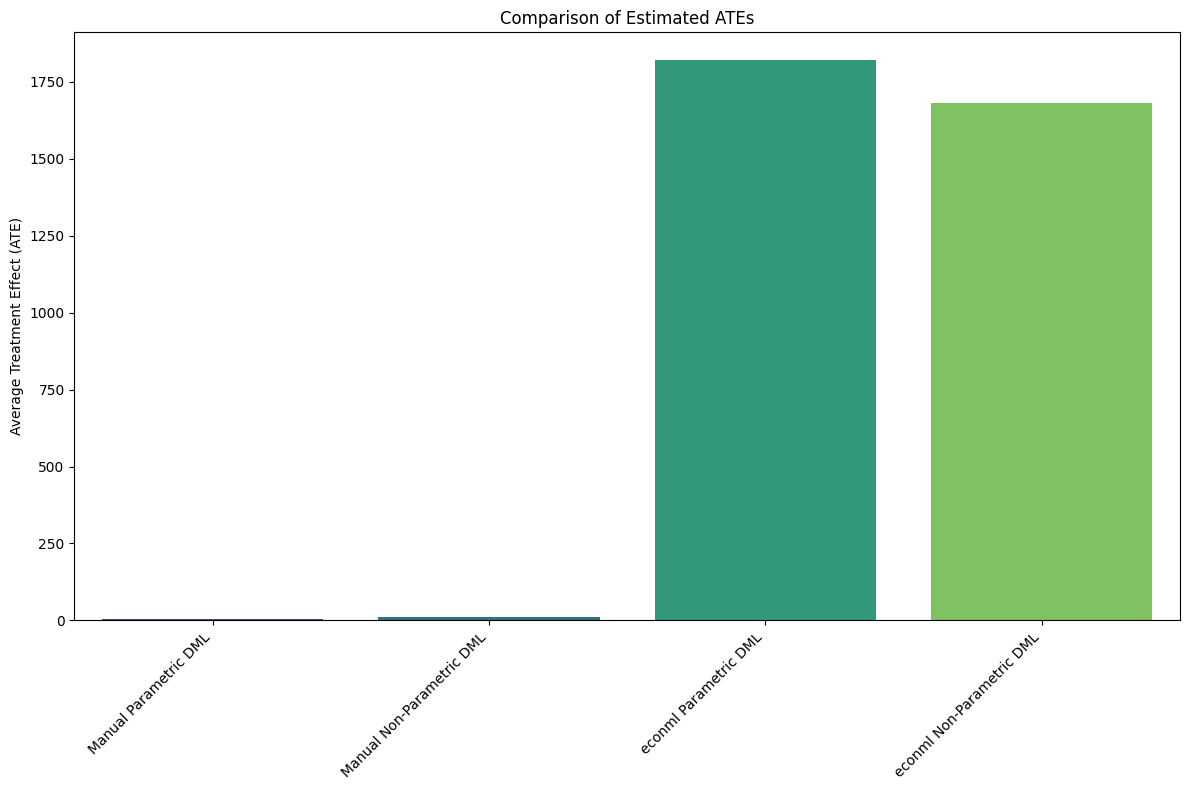

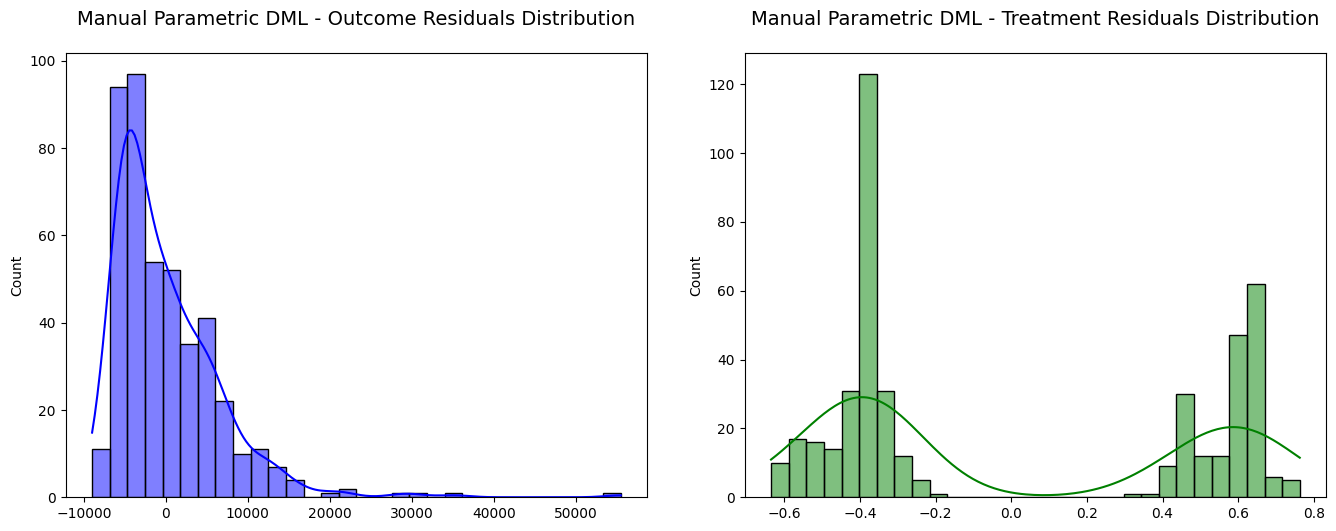

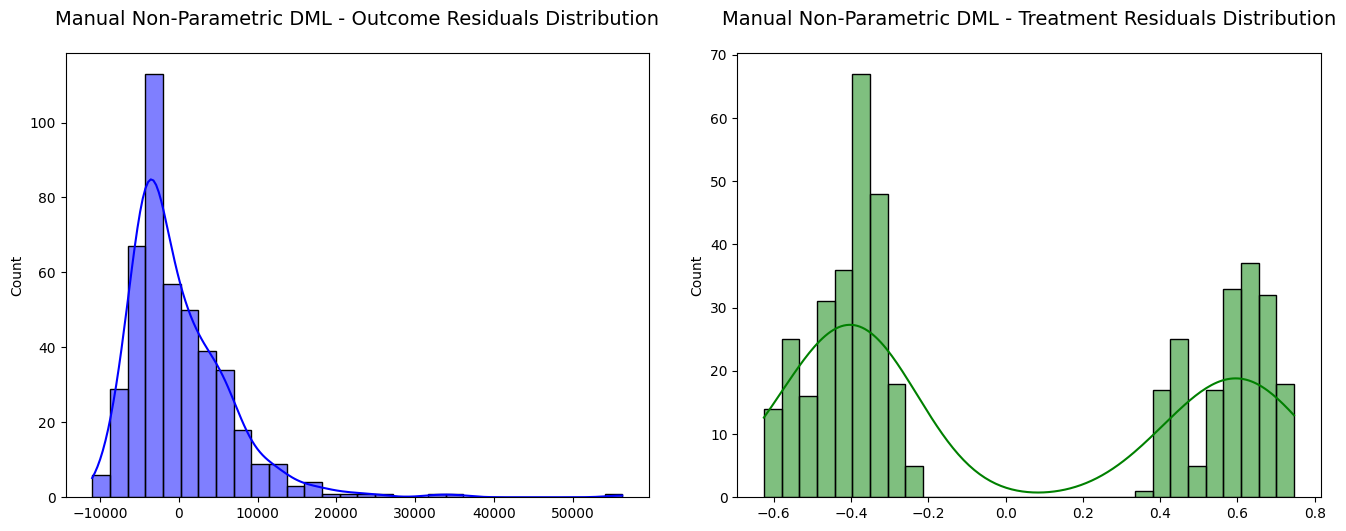

In [16]:
# Visualize and compare results
visualize_results(ates_dict, residuals_dict)

# Model Selection

In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from econml.dml import LinearDML, SparseLinearDML, DML, CausalForestDML
from econml.sklearn_extensions.linear_model import DebiasedLasso, StatsModelsLinearRegression, StatsModelsRLM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [18]:
# Define the data
W = lalonde[['educ', 'black', 'hisp', 'married', 'nodegr']]  # Control variables
X = lalonde[['age']]  # Covariate that might modify treatment effect
T = lalonde['treat'].values  # Treatment variable
Y = lalonde['re78'].values  # Outcome variable

In [19]:
# Splitting data into training and testing sets
X_train, X_test, T_train, T_test, Y_train, Y_test, W_train, W_test = train_test_split(X, T, Y, W, test_size=0.3, random_state=123)

In [20]:
# Model 1: Default Linear DML
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestRegressor(),
                random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred = est.effect(X_test)

# Model 2: SparseLinearDML with Polynomial Features degree=3
est1 = SparseLinearDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       featurizer=PolynomialFeatures(degree=3),
                       random_state=123)
est1.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred1 = est1.effect(X_test)

# Model 3: DML with Polynomial Features degree=10 and Lasso
est2 = DML(model_y=RandomForestRegressor(),
           model_t=RandomForestRegressor(),
           model_final=Lasso(alpha=0.1, fit_intercept=False, max_iter=10000),
           featurizer=PolynomialFeatures(degree=10),
           random_state=123)
est2.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred2 = est2.effect(X_test)

# Model 4: CausalForestDML
est3 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       criterion='mse', n_estimators=1000,
                       min_impurity_decrease=0.001,
                       random_state=123)
est3.tune(Y_train, T_train, X=X_train, W=W_train)
est3.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred3 = est3.effect(X_test)

# Model 5: DML with DebiasedLasso as the final model
est4 = DML(model_y=RandomForestRegressor(),
           model_t=RandomForestRegressor(),
           model_final=DebiasedLasso(fit_intercept=False, max_iter=10000),
           featurizer=PolynomialFeatures(degree=2, include_bias=False),
           random_state=123)
est4.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred4 = est4.effect(X_test)

# Model 6: DML with StatsModelsLinearRegression
est5 = DML(model_y=RandomForestRegressor(),
           model_t=RandomForestRegressor(),
           model_final=StatsModelsLinearRegression(fit_intercept=False),
           featurizer=PolynomialFeatures(degree=2, include_bias=False),
           random_state=123)
est5.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred5 = est5.effect(X_test)

# Model 7: DML with StatsModelsRLM
est6 = DML(model_y=RandomForestRegressor(),
           model_t=RandomForestRegressor(),
           model_final=StatsModelsRLM(fit_intercept=False),
           featurizer=PolynomialFeatures(degree=2, include_bias=False),
           random_state=123)
est6.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred6 = est6.effect(X_test)

The number of features in the final model (< 5) is too small for a sparse model. We recommend using the LinearDML estimator for this low-dimensional setting.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.021e+09, tolerance: 1.435e+06


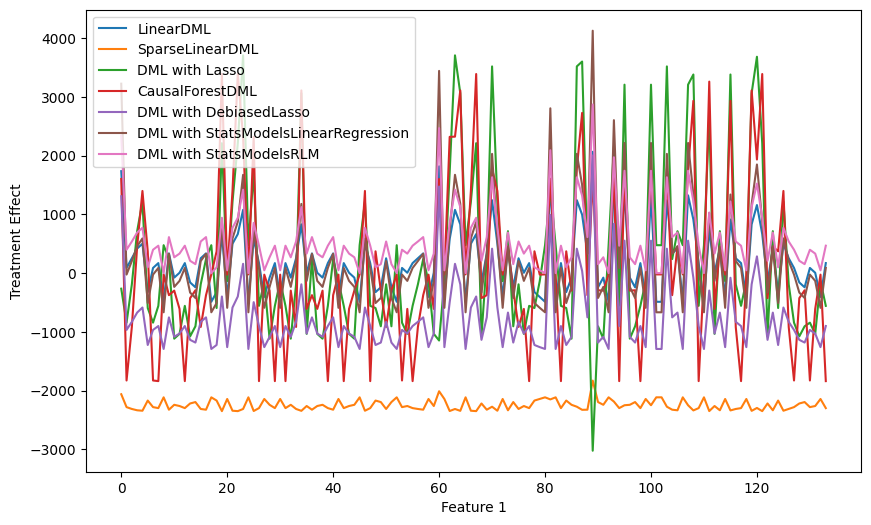

In [21]:
# Plotting the treatment effects of all models
plt.figure(figsize=(10,6))
plt.plot(te_pred, label='LinearDML')
plt.plot(te_pred1, label='SparseLinearDML')
plt.plot(te_pred2, label='DML with Lasso')
plt.plot(te_pred3, label='CausalForestDML')
plt.plot(te_pred4, label='DML with DebiasedLasso')
plt.plot(te_pred5, label='DML with StatsModelsLinearRegression')
plt.plot(te_pred6, label='DML with StatsModelsRLM')
plt.ylabel('Treatment Effect')
plt.xlabel('Feature 1')
plt.legend()
plt.show()

In [22]:
!pip install -q imgkit > /dev/null 2>&1
!apt-get install -y wkhtmltopdf > /dev/null 2>&1

In [23]:
# Selecting the best model
score = {}
score["LinearDML"] = est.score(Y_test, T_test, X=X_test, W=W_test)
score["SparseLinearDML"] = est1.score(Y_test, T_test, X=X_test, W=W_test)
score["DML with Lasso"] = est2.score(Y_test, T_test, X=X_test, W=W_test)
score["CausalForestDML"] = est3.score(Y_test, T_test, X=X_test, W=W_test)
score["DML with DebiasedLasso"] = est4.score(Y_test, T_test, X=X_test, W=W_test)
score["DML with StatsModelsLinearRegression"] = est5.score(Y_test, T_test, X=X_test, W=W_test)
score["DML with StatsModelsRLM"] = est6.score(Y_test, T_test, X=X_test, W=W_test)

# Print scores and best model
print("Scores for models:", score)
print("Best model selected by score: ", min(score, key=lambda x: score[x]), "\n")

Scores for models: {'LinearDML': 64726644.4123741, 'SparseLinearDML': 70963831.21818858, 'DML with Lasso': 63874260.72710777, 'CausalForestDML': 65731630.55096666, 'DML with DebiasedLasso': 66813118.765274845, 'DML with StatsModelsLinearRegression': 65264462.417035446, 'DML with StatsModelsRLM': 63912949.082701616}
Best model selected by score:  DML with Lasso 



In [24]:
# Create a DataFrame of the scores
scores_df = pd.DataFrame(list(score.items()), columns=['Model', 'Score'])
scores_df = scores_df.sort_values(by='Score', ascending=True)
scores_df = scores_df.set_index('Model')

# Style the DataFrame
styled_df = scores_df.style.set_table_styles(
    [{'selector': 'th.col0', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
     {'selector': 'th', 'props': [('text-align', 'center')]}]
).set_properties(**{'text-align': 'center'}).format(precision=3)
styled_df = styled_df.highlight_min(color='yellow', axis=0)
styled_df = styled_df.set_caption("Model Performance Scores")
styled_df

,Score
Model,
DML with Lasso,63874260.727
DML with StatsModelsRLM,63912949.083
LinearDML,64726644.412
DML with StatsModelsLinearRegression,65264462.417
CausalForestDML,65731630.551
DML with DebiasedLasso,66813118.765
SparseLinearDML,70963831.218


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


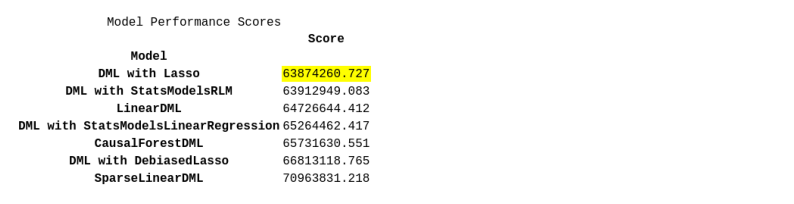

In [25]:
import imgkit
from PIL import Image

# Save the styled DataFrame to an HTML file
styled_df.to_html('styled_dataframe.html')

# Convert the HTML file to an image
imgkit.from_file('styled_dataframe.html', 'styled_dataframe.png')

# Load and display the image
img = Image.open('styled_dataframe.png')
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

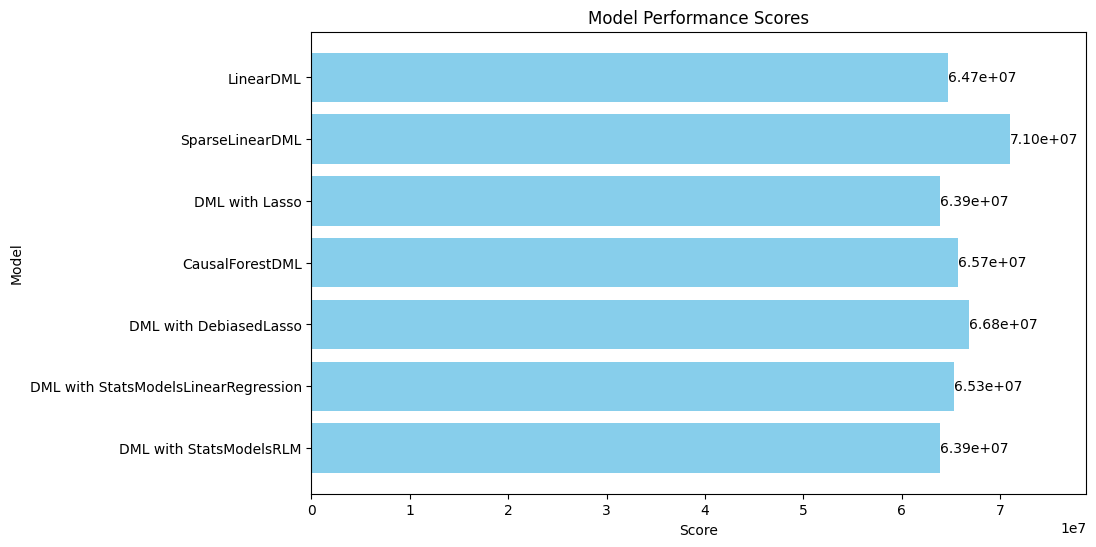

In [26]:
# Plotting the scores
plt.figure(figsize=(10, 6))
model_names = list(score.keys())
model_scores = list(score.values())

plt.barh(model_names, model_scores, color='skyblue')

# Adding the scores in scientific notation next to the bars
for index, value in enumerate(model_scores):
    plt.text(value, index, f'{value:.2e}', va='center', ha='left')

# Adjust x-axis limits to add more space on the right
plt.xlim(0, max(model_scores) * 1.11)

plt.xlabel('Score')
plt.ylabel('Model')
plt.title('Model Performance Scores')
plt.gca().invert_yaxis()
plt.show()